In [4]:
!pip install numpy pandas scikit-learn tensorflow lxml matplotlib network

  Preparing metadata (setup.py) ... done
  Created wheel for network: filename=network-0.1-py3-none-any.whl size=3138 sha256=5ee37cc47fb4f427aa0046f6d9ba27e93516761347823aa558dd53bee579681a
  Stored in directory: /root/.cache/pip/wheels/3a/9a/a4/341d3b109494a43a5cdd444ca83be3a4bfe8c1267ad9f85332
Successfully built network


In [6]:
# -*- coding: utf-8 -*-
# Cell 1: Setup, Imports, Configuration, and Utilities

# --- Standard Libraries ---
import os
import gc
import time
import pickle
import json
import random
from collections import defaultdict
import xml.etree.ElementTree as ET # Fallback/Reference
from lxml import etree # Primary XML parser

# --- Data Handling & ML ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_curve
import sklearn.metrics as m

# --- TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Lambda, Layer, Activation, Dot, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

print(f"TensorFlow Version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# ========================= Configuration Constants =========================
RAW_DATA_DIR = './raw_data'
PROCESSED_DATA_DIR = './data'
LOG_DIR = './log'
MODEL_SAVED_DIR = './ckpt'
DRUGBANK_XML_FILE = os.path.join(RAW_DATA_DIR, 'full database.xml') # Ensure this file exists in Colab
DATASET_NAME = 'drugbank'

# Ensure directories exist
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_SAVED_DIR, exist_ok=True)

# --- File Name Templates ---
# (Keep these consistent across cells)
DRUG_VOCAB_TEMPLATE = '{dataset}_drug_vocab.pkl'
ENTITY_VOCAB_TEMPLATE = '{dataset}_entity_vocab.pkl'
RELATION_VOCAB_TEMPLATE = '{dataset}_relation_vocab.pkl'
ADJ_ENTITY_TEMPLATE = '{dataset}_adj_entity.npy'
ADJ_RELATION_TEMPLATE = '{dataset}_adj_relation.npy'
KG_FILE_TEMPLATE = '{dataset}_train2id.txt'
EXAMPLE_FILE_TEMPLATE = '{dataset}_approved_example.txt' # Raw positive examples
FINAL_TRAIN_DATA_FILE = '{dataset}_final_train_data.npy' # Combined pos/neg samples
FINAL_VALID_DATA_FILE = '{dataset}_final_valid_data.npy'
FINAL_TEST_DATA_FILE = '{dataset}_final_test_data.npy'
ENTITY2ID_FILE_TEMPLATE = '{dataset}_entity2id.txt' # For reference
PERFORMANCE_LOG = 'kgcn_performance.log'
RESULT_LOG_TEMPLATE = '{dataset}_result.txt'

# ========================= Utility Functions =========================
def format_filename(_dir: str, filename_template: str, **kwargs):
    """Obtain the filename."""
    filename = os.path.join(_dir, filename_template.format(**kwargs))
    return filename

def pickle_load(filename: str):
    """Load object from pickle file."""
    try:
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
        print(f'Logging Info - Loaded: {filename}')
        return obj
    except FileNotFoundError:
        print(f'Logging Error - File not found: {filename}')
        return None
    except EOFError:
        print(f'Logging Error - Cannot load (EOFError): {filename}')
        return None
    except Exception as e:
        print(f'Logging Error - General error loading {filename}: {e}')
        return None

def pickle_dump(filename: str, obj):
    """Save object to pickle file."""
    try:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f)
        print(f'Logging Info - Saved: {filename}')
    except Exception as e:
        print(f'Logging Error - Failed to save {filename}: {e}')

def write_log(filename: str, log, mode='w'):
    """Write log data to a file."""
    try:
        with open(filename, mode) as writer:
            writer.write('\n')
            json.dump(log, writer, indent=4, ensure_ascii=False)
    except Exception as e:
        print(f"Error writing log to {filename}: {e}")

def get_optimizer(op_type, learning_rate):
    """Get Keras optimizer instance."""
    if op_type == 'sgd':
        return optimizers.SGD(learning_rate)
    elif op_type == 'rmsprop':
        return optimizers.RMSprop(learning_rate)
    elif op_type == 'adagrad':
        return optimizers.Adagrad(learning_rate)
    elif op_type == 'adadelta':
        return optimizers.Adadelta(learning_rate)
    elif op_type == 'adam':
        return optimizers.Adam(learning_rate, clipnorm=5)
    else:
        raise ValueError('Optimizer Not Understood: {}'.format(op_type))

print("Cell 1: Setup Complete.")

TensorFlow Version: 2.18.0
Num GPUs Available: 0
Cell 1: Setup Complete.


In [8]:
# Cell 2: XML Parsing and Initial Data Formatting (Corrected iterparse call)

# ========================= XML Parsing Function (lxml) =========================
def parse_drugbank_xml_lxml(xml_file):
    """Parses DrugBank XML using lxml.etree.iterparse."""
    print(f"Parsing DrugBank XML using lxml: {xml_file}...")
    if not os.path.exists(xml_file):
        raise FileNotFoundError(f"XML file not found: {xml_file}")

    drugs = {}
    entities = {}
    relations = set()
    ddi_interactions = set()

    # Define context with recovery mode and encoding directly in iterparse
    # REMOVED: parser = etree.XMLParser(recover=True, encoding='utf-8')
    try:
        context = etree.iterparse(xml_file,
                                  events=('end',),
                                  tag='{http://www.drugbank.ca}drug',
                                  recover=True, # Pass recover flag directly
                                  encoding='utf-8') # Specify encoding
    except Exception as e:
        print(f"Error initializing iterparse: {e}")
        return None, None, None, None, None # Return None to indicate failure

    start_time = time.time()
    drug_count = 0
    ns_map = {'db': 'http://www.drugbank.ca'}
    relation_map = {
        'targets': 'targets', 'enzymes': 'enzyme_interaction',
        'transporters': 'transporter_interaction', 'carriers': 'carrier_interaction',
        'ddi': 'interacts_with'
    }
    all_relation_types = set(relation_map.values())

    parsing_errors = 0
    for event, drug_elem in context:
        drug_count += 1
        if drug_count % 1000 == 0: print(f"  Processed {drug_count} drugs...")

        try:
            primary_id_elem = drug_elem.xpath('./db:drugbank-id[@primary="true"]/text()', namespaces=ns_map)
            primary_id = primary_id_elem[0] if primary_id_elem else None
            if not primary_id:
                # Cleanup handled in finally block
                continue # Skip if no primary ID

            name_elem = drug_elem.xpath('./db:name/text()', namespaces=ns_map)
            name = name_elem[0] if name_elem else f"Unknown_{primary_id}"
            drugs[primary_id] = name
            entities[primary_id] = {'name': name, 'type': 'drug'}

            # Extract Relations
            for rel_tag in ['targets', 'enzymes', 'transporters', 'carriers']:
                # Corrected XPath to handle potential nesting if needed (e.g., within <target>)
                entity_elements = drug_elem.xpath(f'./db:{rel_tag}/db:{rel_tag[:-1]}', namespaces=ns_map)
                for entity_elem in entity_elements:
                    # Prioritize polypeptide-id if it exists, otherwise use generic id
                    target_id_elems = entity_elem.xpath('.//db:polypeptide-id/text() | .//db:id/text()', namespaces=ns_map)
                    target_id = target_id_elems[0] if target_id_elems else None
                    if target_id:
                        target_name_elems = entity_elem.xpath('.//db:name/text()', namespaces=ns_map)
                        target_name = target_name_elems[0] if target_name_elems else f"Unknown_{target_id}"
                        entity_type = 'protein'
                        if target_id not in entities:
                            entities[target_id] = {'name': target_name, 'type': entity_type}
                        relations.add((primary_id, relation_map[rel_tag], target_id))
                        all_relation_types.add(relation_map[rel_tag])

            # Extract DDIs
            interaction_elements = drug_elem.xpath('./db:drug-interactions/db:drug-interaction', namespaces=ns_map)
            for interaction_elem in interaction_elements:
                interactor_id_elem = interaction_elem.xpath('./db:drugbank-id/text()', namespaces=ns_map)
                interactor_id = interactor_id_elem[0] if interactor_id_elem else None
                if interactor_id:
                    pair = tuple(sorted((primary_id, interactor_id)))
                    ddi_interactions.add(pair)
                    relations.add((primary_id, relation_map['ddi'], interactor_id))
                    all_relation_types.add(relation_map['ddi'])

        except Exception as e:
             parsing_errors += 1
             if parsing_errors < 20: # Report first few errors
                 print(f"Error processing drug element near count {drug_count}: {e}")
             elif parsing_errors == 20:
                 print("...(suppressing further parsing errors)...")
             # Recovery mode should allow continuing, but log the issue
        finally:
            # Memory cleanup is crucial for iterparse
            if drug_elem is not None:
                 drug_elem.clear()
                 # Clear previous siblings efficiently
                 parent = drug_elem.getparent()
                 if parent is not None:
                     while drug_elem.getprevious() is not None:
                         del parent[0]


    end_time = time.time()
    print(f"Finished parsing {drug_count} drug elements in {end_time - start_time:.2f} seconds.")
    if parsing_errors > 0:
        print(f"Encountered {parsing_errors} errors during element processing (recovery attempted).")

    # --- Post-process and Validate ---
    # (Keep this part the same as before)
    valid_ddi_interactions = set()
    valid_relations = set()
    known_drug_ids = set(drugs.keys())

    print("Validating relations and DDI pairs...")
    for h, r, t in relations:
        if h in entities and t in entities and r in relation_map.values(): # Ensure relation type is known
            valid_relations.add((h, r, t))

    for d1, d2 in ddi_interactions:
        if d1 in known_drug_ids and d2 in known_drug_ids:
            valid_ddi_interactions.add((d1, d2))

    print(f"Found {len(drugs)} drugs, {len(entities)} total entities.")
    print(f"Found {len(valid_ddi_interactions)} unique known DDI pairs.")
    print(f"Found {len(valid_relations)} valid relation triples.")

    return drugs, entities, valid_relations, valid_ddi_interactions, list(all_relation_types)


# ========================= Data Formatting Function =========================
# (Keep this function exactly the same as before)
def format_and_save_data(drugs, entities, relations, ddi_interactions, all_relation_types, dataset_name):
    """Formats extracted data and saves to files."""
    print("Formatting and saving data...")
    # Create Vocabs
    # Check if inputs are valid before proceeding
    if not drugs or not entities:
        print("Error: Empty drugs or entities dictionary passed to format_and_save_data.")
        return None, None, None, None, None

    drug_vocab = {name: i for i, name in enumerate(drugs.keys())}
    # Ensure entities dict is not empty before getting keys
    entity_vocab = {name: i for i, name in enumerate(entities.keys())} if entities else {}
    # Ensure relation types list is not empty
    relation_vocab = {name: i for i, name in enumerate(sorted(all_relation_types))} if all_relation_types else {}

    # Check if vocabs were created
    if not drug_vocab or not entity_vocab or not relation_vocab:
         print("Error: Failed to create one or more vocabularies (drugs/entities/relations might be empty).")
         # Decide how to handle - return None or empty structures
         return None, None, None, None, None


    # Save entity2id file
    entity2id_filepath = format_filename(PROCESSED_DATA_DIR, ENTITY2ID_FILE_TEMPLATE, dataset=dataset_name)
    with open(entity2id_filepath, 'w', encoding='utf8') as f_ent:
        f_ent.write(f"{len(drugs)}\n")
        for drug_id_str, _ in drugs.items():
            if drug_id_str in entity_vocab:
                f_ent.write(f"{drug_id_str}\t{entity_vocab[drug_id_str]}\n")
            else:
                print(f"Warning: Drug ID {drug_id_str} not found in final entity_vocab during entity2id save.")
    print(f"Saved entity2id reference file to: {entity2id_filepath}")

    # Save KG triples
    kg_filepath = format_filename(PROCESSED_DATA_DIR, KG_FILE_TEMPLATE, dataset=dataset_name)
    kg_triples_idx = []
    valid_triple_count = 0
    with open(kg_filepath, 'w', encoding='utf8') as f_kg:
        f_kg.write("COUNT_PLACEHOLDER\n")
        for h, r, t in relations:
            # Double check existence in vocabs
            if h in entity_vocab and r in relation_vocab and t in entity_vocab:
                head_idx = entity_vocab[h]
                rel_idx = relation_vocab[r]
                tail_idx = entity_vocab[t]
                f_kg.write(f"{head_idx} {tail_idx} {rel_idx}\n")
                kg_triples_idx.append((head_idx, tail_idx, rel_idx))
                valid_triple_count += 1
            else:
                # This shouldn't happen often if validation in parse function works
                 print(f"Warning: Skipping triple due to missing vocab entry during save: {h}, {r}, {t}")

    # Update count only if triples were written
    if valid_triple_count > 0:
        try:
            with open(kg_filepath, 'r+', encoding='utf8') as f_kg:
                content = f_kg.read()
                f_kg.seek(0, 0)
                f_kg.write(content.replace("COUNT_PLACEHOLDER", str(valid_triple_count), 1))
        except Exception as e:
            print(f"Error updating triple count in {kg_filepath}: {e}")
    else:
        # If no triples, overwrite placeholder with 0
        try:
            with open(kg_filepath, 'w', encoding='utf8') as f_kg: # Overwrite
                f_kg.write("0\n")
        except Exception as e:
             print(f"Error writing 0 count to {kg_filepath}: {e}")

    print(f"Saved {valid_triple_count} KG triples to {kg_filepath}")


    # Save POSITIVE DDI examples
    example_filepath = format_filename(PROCESSED_DATA_DIR, EXAMPLE_FILE_TEMPLATE, dataset=dataset_name)
    ddi_examples_pos = []
    with open(example_filepath, 'w', encoding='utf8') as f_ex:
        for d1, d2 in ddi_interactions:
            # Double check existence in drug_vocab
            if d1 in drug_vocab and d2 in drug_vocab:
                idx1 = drug_vocab[d1]
                idx2 = drug_vocab[d2]
                f_ex.write(f"{idx1}\t{idx2}\t1\n")
                ddi_examples_pos.append([idx1, idx2, 1])
            else:
                 print(f"Warning: Skipping DDI pair save due to missing drug vocab entry: {d1}, {d2}")

    print(f"Saved {len(ddi_examples_pos)} positive DDI examples to {example_filepath}")


    # Save Vocabularies
    pickle_dump(format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=dataset_name), drug_vocab)
    pickle_dump(format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=dataset_name), entity_vocab)
    pickle_dump(format_filename(PROCESSED_DATA_DIR, RELATION_VOCAB_TEMPLATE, dataset=dataset_name), relation_vocab)

    # Return numpy array for positive examples
    return drug_vocab, entity_vocab, relation_vocab, kg_triples_idx, np.array(ddi_examples_pos) if ddi_examples_pos else np.empty((0,3), dtype=int)


# ========================= Execution =========================
# (Keep this part the same as before)
OVERWRITE_PREPROCESSING_STEP1 = True
drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=DATASET_NAME)
run_parsing = OVERWRITE_PREPROCESSING_STEP1 or not os.path.exists(drug_vocab_path)

if run_parsing:
    print("\n--- Running Step 1 & 2: XML Parsing and Data Formatting ---")
    try:
        if not os.path.exists(DRUGBANK_XML_FILE):
             print(f"ERROR: Input XML file not found at {DRUGBANK_XML_FILE}")
             raise FileNotFoundError("Input XML missing")
        else:
            parsed_data = parse_drugbank_xml_lxml(DRUGBANK_XML_FILE)
            if parsed_data[0] is not None: # Check if parsing succeeded
                 drugs, entities, relations, ddi_interactions, rel_types = parsed_data
                 # Check if essential data structures are non-empty before formatting
                 if drugs and entities:
                     format_and_save_data(
                         drugs, entities, relations, ddi_interactions, rel_types, DATASET_NAME
                     )
                     print("--- Step 1 & 2 Complete ---")
                 else:
                     print("Error: Parsing resulted in empty drugs or entities. Formatting aborted.")
            else:
                 print("Error: XML Parsing failed. Cannot proceed.")

    except FileNotFoundError:
        pass # Error already printed
    except Exception as e:
        print(f"An error occurred during preprocessing Step 1 & 2: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\n--- Skipping Step 1 & 2: Preprocessed files likely exist ---")

print("Cell 2: Processing Complete.")


--- Running Step 1 & 2: XML Parsing and Data Formatting ---
Parsing DrugBank XML using lxml: ./raw_data/full database.xml...
  Processed 1000 drugs...
  Processed 2000 drugs...
  Processed 3000 drugs...
  Processed 4000 drugs...
  Processed 5000 drugs...
  Processed 6000 drugs...
  Processed 7000 drugs...
  Processed 8000 drugs...
  Processed 9000 drugs...
  Processed 10000 drugs...
  Processed 11000 drugs...
  Processed 12000 drugs...
  Processed 13000 drugs...
  Processed 14000 drugs...
Finished parsing 14741 drug elements in 2.89 seconds.
Validating relations and DDI pairs...
Found 153 drugs, 982 total entities.
Found 1114 unique known DDI pairs.
Found 3568 valid relation triples.
Formatting and saving data...
Saved entity2id reference file to: ./data/drugbank_entity2id.txt
Saved 3568 KG triples to ./data/drugbank_train2id.txt
Saved 1114 positive DDI examples to ./data/drugbank_approved_example.txt
Logging Info - Saved: ./data/drugbank_drug_vocab.pkl
Logging Info - Saved: ./data/dr

In [9]:
# Cell 3: Negative Sampling and Data Splitting

# ========================= Negative Sampling Function =========================
def generate_negative_samples(positive_samples, drug_vocab_size, num_negative_ratio=1):
    """Generates negative DDI samples."""
    print("Generating negative DDI samples...")
    if positive_samples.shape[0] == 0:
        print("Warning: No positive samples provided.")
        return np.array([])

    pos_pairs = set(tuple(sorted((r[0], r[1]))) for r in positive_samples)
    num_neg_samples_to_gen = positive_samples.shape[0] * num_negative_ratio
    neg_samples = []
    max_attempts = num_neg_samples_to_gen * 100
    attempts = 0

    while len(neg_samples) < num_neg_samples_to_gen and attempts < max_attempts:
        attempts += 1
        d1_idx = random.randint(0, drug_vocab_size - 1)
        d2_idx = random.randint(0, drug_vocab_size - 1)
        if d1_idx == d2_idx: continue
        pair = tuple(sorted((d1_idx, d2_idx)))
        if pair not in pos_pairs:
            neg_samples.append([d1_idx, d2_idx, 0])
            pos_pairs.add(pair) # Avoid resampling this negative pair

    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts for negative sampling. Generated {len(neg_samples)} samples.")
    print(f"Generated {len(neg_samples)} negative samples.")
    return np.array(neg_samples)

# ========================= Execution =========================
OVERWRITE_PREPROCESSING_STEP2 = True # Set to False to skip if final files exist

final_train_path = format_filename(PROCESSED_DATA_DIR, FINAL_TRAIN_DATA_FILE, dataset=DATASET_NAME)
final_valid_path = format_filename(PROCESSED_DATA_DIR, FINAL_VALID_DATA_FILE, dataset=DATASET_NAME)
final_test_path = format_filename(PROCESSED_DATA_DIR, FINAL_TEST_DATA_FILE, dataset=DATASET_NAME)

run_sampling_split = OVERWRITE_PREPROCESSING_STEP2 or not all(os.path.exists(p) for p in [final_train_path, final_valid_path, final_test_path])

if run_sampling_split:
    print("\n--- Running Step 2b: Negative Sampling and Data Splitting ---")
    # Load positive examples and drug vocab
    pos_example_path = format_filename(PROCESSED_DATA_DIR, EXAMPLE_FILE_TEMPLATE, dataset=DATASET_NAME)
    drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=DATASET_NAME)

    drug_vocab = pickle_load(drug_vocab_path)
    try:
        ddi_examples_pos = np.loadtxt(pos_example_path, dtype=np.int64, delimiter='\t')
        if len(ddi_examples_pos.shape) == 1: ddi_examples_pos = ddi_examples_pos.reshape(1, -1)
    except Exception as e:
        print(f"Error loading positive examples from {pos_example_path}: {e}")
        ddi_examples_pos = None # Indicate error

    if drug_vocab is None or ddi_examples_pos is None:
        print("Error: Cannot perform negative sampling. Missing drug vocab or positive examples.")
    else:
        ddi_examples_neg = generate_negative_samples(ddi_examples_pos, len(drug_vocab), num_negative_ratio=1)
        if ddi_examples_neg.size == 0 and ddi_examples_pos.shape[0] > 0 :
             print("Warning: Could not generate negative samples. Proceeding with positive only (not ideal).")
             all_ddi_data = ddi_examples_pos
        elif ddi_examples_neg.size == 0 and ddi_examples_pos.shape[0] == 0:
             print("Error: No positive or negative samples available.")
             all_ddi_data = np.array([])
        else:
             all_ddi_data = np.concatenate([ddi_examples_pos, ddi_examples_neg], axis=0)

        if all_ddi_data.size > 0:
            np.random.shuffle(all_ddi_data)
            print(f"Total examples (Positive + Negative): {len(all_ddi_data)}")

            # Split Data
            y = all_ddi_data[:, 2]
            try:
                train_data, temp_data, y_train, y_temp = train_test_split(
                    all_ddi_data, y, train_size=0.8, random_state=42, stratify=y)
                valid_data, test_data, y_valid, y_test = train_test_split(
                    temp_data, y_temp, train_size=0.5, random_state=42, stratify=y_temp)

                np.save(final_train_path, train_data)
                np.save(final_valid_path, valid_data)
                np.save(final_test_path, test_data)
                print(f"Saved final split data - Train: {len(train_data)}, Valid: {len(valid_data)}, Test: {len(test_data)}")
                print("--- Step 2b Complete ---")
            except ValueError as e:
                print(f"Error during data splitting: {e}")
                np.save(format_filename(PROCESSED_DATA_DIR, f"{DATASET_NAME}_combined_samples.npy"), all_ddi_data)
                print("Saved combined samples due to split error.")
        else:
             print("Skipping data splitting as there are no samples.")
else:
    print("\n--- Skipping Step 2b: Final split data files likely exist ---")

print("Cell 3: Processing Complete.")


--- Running Step 2b: Negative Sampling and Data Splitting ---
Logging Info - Loaded: ./data/drugbank_drug_vocab.pkl
Generating negative DDI samples...
Generated 1114 negative samples.
Total examples (Positive + Negative): 2228
Saved final split data - Train: 1782, Valid: 223, Test: 223
--- Step 2b Complete ---
Cell 3: Processing Complete.


In [10]:
# Cell 4: Adjacency Matrix Construction

# ========================= Adjacency Matrix Function =========================
def build_adjacency_matrices(entity_vocab_size, kg_filepath, neighbor_sample_size, dataset_name):
    """Builds and saves adjacency matrices."""
    print("Building adjacency matrices...")

    adj_entity_path = format_filename(PROCESSED_DATA_DIR, ADJ_ENTITY_TEMPLATE, dataset=dataset_name)
    adj_relation_path = format_filename(PROCESSED_DATA_DIR, ADJ_RELATION_TEMPLATE, dataset=dataset_name)
    n_entity = entity_vocab_size
    print(f"Entity vocab size: {n_entity}")

    kg = defaultdict(list)
    print(f"Reading KG file: {kg_filepath}")
    try:
        with open(kg_filepath, 'r', encoding='utf8') as reader:
            next(reader) # Skip count line
            for line_num, line in enumerate(reader):
                parts = line.strip().split(' ')
                if len(parts) == 3:
                    try:
                        head_idx, tail_idx, rel_idx = map(int, parts)
                        if 0 <= head_idx < n_entity and 0 <= tail_idx < n_entity:
                            kg[head_idx].append((tail_idx, rel_idx))
                            kg[tail_idx].append((head_idx, rel_idx))
                        else:
                             print(f"Warning: Index out of bounds ({head_idx}, {tail_idx}) vs {n_entity} in line {line_num+2}")
                    except ValueError:
                         print(f"Warning: Non-integer index in line {line_num+2}: {line.strip()}")
                elif line.strip(): # Non-empty line that's not 3 parts
                     print(f"Warning: Skipping malformed line {line_num+2} in KG file: {line.strip()}")

    except FileNotFoundError:
        print(f"Error: KG file not found at {kg_filepath}")
        return None, None
    except Exception as e:
        print(f"Error reading KG file {kg_filepath}: {e}")
        return None, None

    print('Constructing adjacency matrices with sampling...')
    adj_entity = np.zeros(shape=(n_entity, neighbor_sample_size), dtype=np.int64)
    adj_relation = np.zeros(shape=(n_entity, neighbor_sample_size), dtype=np.int64)
    nodes_with_neighbors = 0

    for entity_id in range(n_entity):
        all_neighbors = kg.get(entity_id, []) # Use get for safety
        n_neighbor = len(all_neighbors)
        if n_neighbor > 0:
            nodes_with_neighbors += 1
            if n_neighbor >= neighbor_sample_size:
                sampled_indices = np.random.choice(n_neighbor, neighbor_sample_size, replace=False)
            else:
                sampled_indices = np.random.choice(n_neighbor, neighbor_sample_size, replace=True)
            adj_entity[entity_id] = np.array([all_neighbors[i][0] for i in sampled_indices])
            adj_relation[entity_id] = np.array([all_neighbors[i][1] for i in sampled_indices])

    print(f"Found neighbors for {nodes_with_neighbors} / {n_entity} entities.")
    np.save(adj_entity_path, adj_entity)
    print(f'Saved adjacency entity matrix to: {adj_entity_path}')
    np.save(adj_relation_path, adj_relation)
    print(f'Saved adjacency relation matrix to: {adj_relation_path}')
    return adj_entity, adj_relation

# ========================= Execution =========================
OVERWRITE_PREPROCESSING_STEP3 = True # Set to False to skip if .npy files exist

adj_entity_path = format_filename(PROCESSED_DATA_DIR, ADJ_ENTITY_TEMPLATE, dataset=DATASET_NAME)
adj_relation_path = format_filename(PROCESSED_DATA_DIR, ADJ_RELATION_TEMPLATE, dataset=DATASET_NAME)

run_adj_build = OVERWRITE_PREPROCESSING_STEP3 or not all(os.path.exists(p) for p in [adj_entity_path, adj_relation_path])

if run_adj_build:
    print("\n--- Running Step 3: Building Adjacency Matrices ---")
    entity_vocab_path = format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=DATASET_NAME)
    kg_file_path = format_filename(PROCESSED_DATA_DIR, KG_FILE_TEMPLATE, dataset=DATASET_NAME)

    entity_vocab = pickle_load(entity_vocab_path)
    if entity_vocab is None:
        print("Error: Entity vocabulary not found. Cannot build adjacency matrices.")
    else:
        # Define neighbor sample size here or load from a config object if preferred
        NEIGHBOR_SAMPLE_SIZE = 16
        adj_entity, adj_relation = build_adjacency_matrices(
            len(entity_vocab), kg_file_path, NEIGHBOR_SAMPLE_SIZE, DATASET_NAME
        )
        if adj_entity is not None:
             print("--- Step 3 Complete ---")
else:
    print("\n--- Skipping Step 3: Adjacency matrix files likely exist ---")

print("Cell 4: Processing Complete.")


--- Running Step 3: Building Adjacency Matrices ---
Logging Info - Loaded: ./data/drugbank_entity_vocab.pkl
Building adjacency matrices...
Entity vocab size: 982
Reading KG file: ./data/drugbank_train2id.txt
Constructing adjacency matrices with sampling...
Found neighbors for 981 / 982 entities.
Saved adjacency entity matrix to: ./data/drugbank_adj_entity.npy
Saved adjacency relation matrix to: ./data/drugbank_adj_relation.npy
--- Step 3 Complete ---
Cell 4: Processing Complete.


In [13]:
# Cell 5: Model Definition (Layers, Base Model, KGCN Model, Callback)
# (Keep all other parts of Cell 5 the same)
# ... (Imports, ModelConfig, Layers definitions remain the same) ...

# ========================= Base Model Class =========================
class BaseModel(object):
    def __init__(self, config: ModelConfig):
        self.config = config
        self.callbacks_internal = [] # Renamed to avoid conflict
        self.model = self.build() # Call build in init

    def add_model_checkpoint(self):
        # --- MODIFICATION START ---
        # Construct filename based on save_weights_only flag
        if self.config.checkpoint_save_weights_only:
            file_extension = ".weights.h5"
        else:
            # .keras is preferred for saving the whole model, but .h5/.hdf5 also works
            file_extension = ".keras" # Or keep as ".hdf5" if preferred for whole model

        filepath = os.path.join(self.config.checkpoint_dir, f'{self.config.exp_name}{file_extension}')
        # --- MODIFICATION END ---

        print(f"Setting ModelCheckpoint to save at: {filepath}")
        self.callbacks_internal.append(ModelCheckpoint(
            filepath=filepath, # Use the correctly formatted filepath
            monitor=self.config.checkpoint_monitor,
            save_best_only=self.config.checkpoint_save_best_only,
            save_weights_only=self.config.checkpoint_save_weights_only,
            mode=self.config.checkpoint_save_weights_mode,
            verbose=self.config.checkpoint_verbose ))
        print('Logging Info - Callback Added: ModelCheckPoint...')

    def add_early_stopping(self):
        # (Keep this method the same)
        self.callbacks_internal.append(EarlyStopping(
            monitor=self.config.early_stopping_monitor, mode=self.config.early_stopping_mode,
            patience=self.config.early_stopping_patience, verbose=self.config.early_stopping_verbose,
            restore_best_weights=True ))
        print('Logging Info - Callback Added: EarlyStopping...')

    def init_callbacks(self):
        # (Keep this method the same)
        self.callbacks_internal = [] # Reset callbacks
        print("Initializing callbacks...")
        if 'modelcheckpoint' in self.config.callbacks_to_add: self.add_model_checkpoint()
        if 'earlystopping' in self.config.callbacks_to_add: self.add_early_stopping()

    def build(self): raise NotImplementedError
    def fit(self, x_train, y_train, x_valid, y_valid): raise NotImplementedError
    def predict(self, x): return self.model.predict(x) # Added predict method

    def score(self, x, y, threshold=0.5):
        # (Keep this method the same)
        y_true = y.flatten()
        y_pred_prob = self.model.predict(x).flatten()
        auc = roc_auc_score(y_true=y_true, y_score=y_pred_prob)
        p, r, _ = precision_recall_curve(y_true=y_true, probas_pred=y_pred_prob)
        aupr = m.auc(r, p)
        y_pred_binary = np.array([1 if prob >= threshold else 0 for prob in y_pred_prob])
        acc = accuracy_score(y_true=y_true, y_pred=y_pred_binary)
        f1 = f1_score(y_true=y_true, y_pred=y_pred_binary)
        return auc, acc, f1, aupr

    def load_weights(self, filename: str):
        # (Keep this method the same)
        print(f"Loading model weights from: {filename}")
        try:
             self.model.load_weights(filename)
             print("Weights loaded successfully.")
        except Exception as e:
             print(f"Error loading weights from {filename}: {e}")

    def load_best_model(self):
        # --- MODIFICATION START ---
        # Construct filename consistent with how it was saved
        if self.config.checkpoint_save_weights_only:
            file_extension = ".weights.h5"
        else:
            file_extension = ".keras" # Or ".hdf5" if you kept that for whole model

        best_model_path = os.path.join(self.config.checkpoint_dir, f'{self.config.exp_name}{file_extension}')
        # --- MODIFICATION END ---

        if os.path.exists(best_model_path):
            print(f'Logging Info - Loading best model weights from: {best_model_path}')
            # Use load_weights because we might only have weights,
            # even if file_extension is .keras/.hdf5 (safer approach)
            self.load_weights(best_model_path)
        else:
            print(f'Logging Warning - Best model file not found: {best_model_path}. Using current model weights.')

    def summary(self): self.model.summary()


# ========================= KGCN Model Class =========================
# (Keep the KGCN class definition exactly the same as before)
class KGCN(BaseModel):
    # ... (No changes needed inside KGCN class itself) ...
    def __init__(self, config):
        super(KGCN, self).__init__(config) # Calls BaseModel.__init__ which calls self.build()

    def get_receptive_field(self, entity):
        adj_entity_tensor = K.constant(self.config.adj_entity, dtype='int64')
        adj_relation_tensor = K.constant(self.config.adj_relation, dtype='int64')
        neigh_ent_list = [entity]
        neigh_rel_list = []
        n_neighbor = self.config.neighbor_sample_size
        for i in range(self.config.n_depth):
            last_entity_indices = K.cast(neigh_ent_list[-1], dtype='int64')
            new_neigh_ent = K.gather(adj_entity_tensor, last_entity_indices)
            new_neigh_rel = K.gather(adj_relation_tensor, last_entity_indices)
            new_shape = (-1, n_neighbor**(i + 1))
            neigh_ent_list.append(K.reshape(new_neigh_ent, new_shape))
            neigh_rel_list.append(K.reshape(new_neigh_rel, new_shape))
        return neigh_ent_list + neigh_rel_list

    def get_neighbor_info(self, drug_embed, rel_embed, ent_embed):
        drug_rel_score = K.sum(tf.multiply(drug_embed, rel_embed), axis=-1, keepdims=True)
        weighted_ent = tf.multiply(drug_rel_score, ent_embed)
        reshaped_size = self.config.neighbor_sample_size
        new_shape = (K.shape(weighted_ent)[0], -1, reshaped_size, self.config.embed_dim)
        weighted_ent_reshaped = K.reshape(weighted_ent, new_shape)
        neighbor_embed_aggregated = K.sum(weighted_ent_reshaped, axis=2)
        return neighbor_embed_aggregated

    def build(self):
        # --- Inputs, Embeddings, Layers --- (Same as before)
        input_drug_one = Input(shape=(1,), name='input_drug_one', dtype='int64')
        input_drug_two = Input(shape=(1,), name='input_drug_two', dtype='int64')
        if not self.config.drug_vocab_size or not self.config.entity_vocab_size or not self.config.relation_vocab_size:
             raise ValueError("Vocab sizes missing in config during build.")
        if self.config.adj_entity is None or self.config.adj_relation is None:
            raise ValueError("Adjacency matrices missing in config during build.")

        drug_embedding_layer = Embedding(input_dim=self.config.drug_vocab_size, output_dim=self.config.embed_dim, embeddings_initializer='glorot_normal', embeddings_regularizer=l2(self.config.l2_weight), name='drug_embedding')
        entity_embedding_layer = Embedding(input_dim=self.config.entity_vocab_size, output_dim=self.config.embed_dim, embeddings_initializer='glorot_normal', embeddings_regularizer=l2(self.config.l2_weight), name='entity_embedding')
        relation_embedding_layer = Embedding(input_dim=self.config.relation_vocab_size, output_dim=self.config.embed_dim, embeddings_initializer='glorot_normal', embeddings_regularizer=l2(self.config.l2_weight), name='relation_embedding')

        drug_one_embed = drug_embedding_layer(input_drug_one)
        receptive_list_d1 = Lambda(self.get_receptive_field, name='receptive_field_drug_one')(input_drug_one)
        neigh_ent_list_d1, neigh_rel_list_d1 = receptive_list_d1[:self.config.n_depth + 1], receptive_list_d1[self.config.n_depth + 1:]
        neigh_ent_embed_list_d1 = [entity_embedding_layer(n) for n in neigh_ent_list_d1]
        neigh_rel_embed_list_d1 = [relation_embedding_layer(n) for n in neigh_rel_list_d1]
        neighbor_embedding_lambda = Lambda(lambda x: self.get_neighbor_info(x[0], x[1], x[2]), name='neighbor_processor')

        current_neigh_ent_embed_d1 = neigh_ent_embed_list_d1
        for depth in range(self.config.n_depth):
            aggregator = Aggregator[self.config.aggregator_type](activation='tanh' if depth == self.config.n_depth - 1 else 'relu', regularizer=l2(self.config.l2_weight), name=f'aggregator_{depth + 1}_drug_one')
            next_neigh_ent_embed_list_d1 = []
            for hop in range(self.config.n_depth - depth):
                neighbor_info_embed = neighbor_embedding_lambda([drug_one_embed, neigh_rel_embed_list_d1[hop], current_neigh_ent_embed_d1[hop + 1]])
                next_entity_embed = aggregator([current_neigh_ent_embed_d1[hop], neighbor_info_embed])
                next_neigh_ent_embed_list_d1.append(next_entity_embed)
            current_neigh_ent_embed_d1 = next_neigh_ent_embed_list_d1
        drug1_final_embed = current_neigh_ent_embed_d1[0]

        drug_two_embed = drug_embedding_layer(input_drug_two)
        receptive_list_d2 = Lambda(self.get_receptive_field, name='receptive_field_drug_two')(input_drug_two)
        neigh_ent_list_d2, neigh_rel_list_d2 = receptive_list_d2[:self.config.n_depth + 1], receptive_list_d2[self.config.n_depth + 1:]
        neigh_ent_embed_list_d2 = [entity_embedding_layer(n) for n in neigh_ent_list_d2]
        neigh_rel_embed_list_d2 = [relation_embedding_layer(n) for n in neigh_rel_list_d2]

        current_neigh_ent_embed_d2 = neigh_ent_embed_list_d2
        for depth in range(self.config.n_depth):
            aggregator = Aggregator[self.config.aggregator_type](activation='tanh' if depth == self.config.n_depth - 1 else 'relu', regularizer=l2(self.config.l2_weight), name=f'aggregator_{depth + 1}_drug_two')
            next_neigh_ent_embed_list_d2 = []
            for hop in range(self.config.n_depth - depth):
                neighbor_info_embed = neighbor_embedding_lambda([drug_two_embed, neigh_rel_embed_list_d2[hop], current_neigh_ent_embed_d2[hop + 1]])
                next_entity_embed = aggregator([current_neigh_ent_embed_d2[hop], neighbor_info_embed])
                next_neigh_ent_embed_list_d2.append(next_entity_embed)
            current_neigh_ent_embed_d2 = next_neigh_ent_embed_list_d2
        drug2_final_embed = current_neigh_ent_embed_d2[0]

        drug1_squeeze_embed = Lambda(lambda x: K.squeeze(x, axis=1), name='squeeze_d1')(drug1_final_embed)
        drug2_squeeze_embed = Lambda(lambda x: K.squeeze(x, axis=1), name='squeeze_d2')(drug2_final_embed)
        dot_product = Lambda(lambda x: K.sum(tf.multiply(x[0], x[1]), axis=-1, keepdims=True), name='dot_product')([drug1_squeeze_embed, drug2_squeeze_embed])
        output_score = Activation('sigmoid', name='output_activation')(dot_product)

        model = Model(inputs=[input_drug_one, input_drug_two], outputs=output_score)
        # Make sure config.optimizer is set before calling build
        if self.config.optimizer is None:
            raise ValueError("Optimizer not set in config before compiling.")
        model.compile(optimizer=self.config.optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(name='aupr', curve='PR')])
        return model


    def add_metrics_callback(self, x_valid, y_valid):
         # (Keep this method the same)
         self.callbacks_internal.append(KGCNMetric(None, None, x_valid, y_valid, # Pass None for train data
                                          self.config.aggregator_type, self.config.dataset, self.config.k_fold))
         print("Logging Info - Callback Added: KGCNMetric...")

    def fit(self, x_train, y_train, x_valid, y_valid):
        # (Keep this method the same)
        self.init_callbacks() # Setup ModelCheckpoint, EarlyStopping
        self.add_metrics_callback(x_valid, y_valid) # Add custom evaluation callback

        print('\nLogging Info - Start training...')
        history = self.model.fit(x=x_train, y=y_train, batch_size=self.config.batch_size,
                                 epochs=self.config.n_epoch, validation_data=(x_valid, y_valid),
                                 callbacks=self.callbacks_internal, verbose=2)
        print('Logging Info - Training finished.')
        return history


# ========================= Evaluation Callback =========================
# (Keep KGCNMetric class definition exactly the same as before)
class KGCNMetric(Callback):
    # ... (No changes needed inside KGCNMetric class itself) ...
    def __init__(self, x_train, y_train, x_valid, y_valid, aggregator_type, dataset, K_fold, threshold=0.5):
        super(KGCNMetric, self).__init__()
        self.x_valid = x_valid # Only need validation data
        self.y_valid = y_valid
        self.aggregator_type = aggregator_type
        self.dataset = dataset
        self.k = K_fold
        self.threshold = threshold
        self.val_logs = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Ensure validation data is in the correct list format for predict
        # Model expects a list [drug1_input, drug2_input]
        x_val_input = self.x_valid if isinstance(self.x_valid, list) else [self.x_valid[:, :1], self.x_valid[:, 1:2]]
        y_pred = self.model.predict(x_val_input).flatten()
        y_true = self.y_valid.flatten()

        try:
            auc = roc_auc_score(y_true=y_true, y_score=y_pred)
            precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
            aupr = m.auc(recall, precision)
            y_pred_binary = np.array([1 if prob >= self.threshold else 0 for prob in y_pred])
            acc = accuracy_score(y_true=y_true, y_pred=y_pred_binary)
            f1 = f1_score(y_true=y_true, y_pred=y_pred_binary)

            logs['val_auc'] = auc
            logs['val_aupr'] = aupr
            logs['val_acc'] = acc
            logs['val_f1'] = f1

            epoch_log = { 'epoch': epoch + 1, 'val_auc': float(auc), 'val_aupr': float(aupr),
                          'val_acc': float(acc), 'val_f1': float(f1),
                          'loss': logs.get('loss'), 'val_loss': logs.get('val_loss') }
            self.val_logs.append(epoch_log)
            # Use \r for carriage return to potentially overwrite previous metrics on the same line in Colab
            print(f" - val_auc: {auc:.4f} - val_aupr: {aupr:.4f} - val_acc: {acc:.4f} - val_f1: {f1:.4f}", end="\r")

        except Exception as e:
            print(f"\nError calculating metrics on epoch {epoch+1}: {e}")
            logs['val_auc'], logs['val_aupr'], logs['val_acc'], logs['val_f1'] = 0.0, 0.0, 0.0, 0.0


print("Cell 5: Model Definitions Complete (with Checkpoint Filename Fix).")

Cell 5: Model Definitions Complete (with Checkpoint Filename Fix).


In [14]:
# Cell 6: Training and Evaluation

# ========================= Main Training Logic =========================
# --- Configuration ---
config = ModelConfig()
config.aggregator_type = 'sum'  # Choose aggregator: 'sum', 'concat', 'neigh'
# Adjust other hyperparameters if needed
# config.embed_dim = 64
# config.lr = 0.001

OVERWRITE_TRAINING = True # Set to False to load existing model if checkpoint exists

print("\n--- Running Step 4 & 5: Model Training and Evaluation ---")
print(f"Using Aggregator: {config.aggregator_type}")

# --- Load necessary data ---
print("Loading data for training...")
drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=config.dataset)
entity_vocab_path = format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=config.dataset)
relation_vocab_path = format_filename(PROCESSED_DATA_DIR, RELATION_VOCAB_TEMPLATE, dataset=config.dataset)
train_data_path = format_filename(PROCESSED_DATA_DIR, FINAL_TRAIN_DATA_FILE, dataset=config.dataset)
valid_data_path = format_filename(PROCESSED_DATA_DIR, FINAL_VALID_DATA_FILE, dataset=config.dataset)
test_data_path = format_filename(PROCESSED_DATA_DIR, FINAL_TEST_DATA_FILE, dataset=config.dataset)
adj_entity_path = format_filename(PROCESSED_DATA_DIR, ADJ_ENTITY_TEMPLATE, dataset=config.dataset)
adj_relation_path = format_filename(PROCESSED_DATA_DIR, ADJ_RELATION_TEMPLATE, dataset=config.dataset)

# Load vocabs
drug_vocab = pickle_load(drug_vocab_path)
entity_vocab = pickle_load(entity_vocab_path)
relation_vocab = pickle_load(relation_vocab_path)
# Load data splits
train_data = np.load(train_data_path) if os.path.exists(train_data_path) else None
valid_data = np.load(valid_data_path) if os.path.exists(valid_data_path) else None
test_data = np.load(test_data_path) if os.path.exists(test_data_path) else None
# Load adjacency matrices
adj_entity = np.load(adj_entity_path) if os.path.exists(adj_entity_path) else None
adj_relation = np.load(adj_relation_path) if os.path.exists(adj_relation_path) else None

# --- Validate loaded data ---
if any(v is None for v in [drug_vocab, entity_vocab, relation_vocab, train_data, valid_data, test_data, adj_entity, adj_relation]):
    print("Error: One or more required data files (.pkl, .npy) not found or failed to load.")
    print("Please ensure Cells 1-4 completed successfully.")
else:
    print("All necessary data loaded successfully.")
    config.drug_vocab_size = len(drug_vocab)
    config.entity_vocab_size = len(entity_vocab)
    config.relation_vocab_size = len(relation_vocab)
    config.adj_entity = adj_entity
    config.adj_relation = adj_relation
    config.neighbor_sample_size = adj_entity.shape[1] # Update from loaded matrix

    # Setup optimizer and experiment name
    config.optimizer = get_optimizer(config.optimizer_type, config.lr)
    config.exp_name = f'kgnn_{config.dataset}_agg_{config.aggregator_type}_emb_{config.embed_dim}_dep_{config.n_depth}_lr_{config.lr}_bs_{config.batch_size}'
    if config.callbacks_to_add:
         callback_str = '_' + '_'.join(config.callbacks_to_add).replace('_modelcheckpoint', '').replace('_earlystopping', '')
         config.exp_name += callback_str

    model_save_path = os.path.join(config.checkpoint_dir, '{}.hdf5'.format(config.exp_name))
    train_log = {'exp_name': config.exp_name, 'batch_size': config.batch_size, 'optimizer': config.optimizer_type,
                 'epoch_count': config.n_epoch, 'learning_rate': config.lr, 'aggregator': config.aggregator_type,
                 'dataset': config.dataset}

    # --- Instantiate and Train ---
    model = KGCN(config) # This calls build() internally
    print("\nModel Summary:")
    model.summary()

    if not os.path.exists(model_save_path) or OVERWRITE_TRAINING:
        start_time = time.time()
        x_train = [train_data[:, :1], train_data[:, 1:2]]
        y_train = train_data[:, 2:]
        x_valid = [valid_data[:, :1], valid_data[:, 1:2]]
        y_valid = valid_data[:, 2:]

        history = model.fit(x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid)

        elapsed_time = time.time() - start_time
        print('\nTraining Complete. Duration: %s' % time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
        train_log['train_time'] = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        train_log['actual_epochs'] = len(history.history.get('loss', []))
    else:
        print(f"\nFound existing model checkpoint: {model_save_path}. Skipping training.")
        # Load weights if skipping training but want to evaluate
        model.load_best_model()


    # --- Evaluate ---
    print('\n--- Evaluating Model ---')
    try:
        # Ensure best weights are loaded (might have been restored by EarlyStopping or loaded above)
        model.load_best_model()

        print('Evaluating on Validation Set:')
        x_valid_eval = [valid_data[:, :1], valid_data[:, 1:2]]
        y_valid_eval = valid_data[:, 2:]
        val_auc, val_acc, val_f1, val_aupr = model.score(x=x_valid_eval, y=y_valid_eval)
        print(f'  Validation - AUC: {val_auc:.4f}, AUPR: {val_aupr:.4f}, ACC: {val_acc:.4f}, F1: {val_f1:.4f}')
        train_log.update({'val_auc': val_auc, 'val_acc': val_acc, 'val_f1': val_f1, 'val_aupr': val_aupr})

        print('Evaluating on Test Set:')
        x_test_eval = [test_data[:, :1], test_data[:, 1:2]]
        y_test_eval = test_data[:, 2:]
        test_auc, test_acc, test_f1, test_aupr = model.score(x=x_test_eval, y=y_test_eval)
        print(f'  Test - AUC: {test_auc:.4f}, AUPR: {test_aupr:.4f}, ACC: {test_acc:.4f}, F1: {test_f1:.4f}')
        train_log.update({'test_auc': test_auc, 'test_acc': test_acc, 'test_f1': test_f1, 'test_aupr': test_aupr})

    except Exception as e:
         print(f"An error occurred during evaluation: {e}")
         import traceback
         traceback.print_exc()
         train_log.update({ 'val_auc': 0, 'val_acc': 0, 'val_f1': 0, 'val_aupr': 0,
                            'test_auc': 0, 'test_acc': 0, 'test_f1': 0, 'test_aupr': 0 })

    # --- Log Final Results ---
    train_log['timestamp'] = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    log_filepath = format_filename(LOG_DIR, PERFORMANCE_LOG)
    write_log(log_filepath, log=train_log, mode='a')
    print(f"\nPerformance log appended to: {log_filepath}")
    print(f"Final Log for this run: {train_log}")

    # --- Cleanup ---
    del model
    gc.collect()
    K.clear_session()
    print("\n--- Step 4 & 5 Complete ---")

print("Cell 6: Processing Complete.")


--- Running Step 4 & 5: Model Training and Evaluation ---
Using Aggregator: sum
Loading data for training...
Logging Info - Loaded: ./data/drugbank_drug_vocab.pkl
Logging Info - Loaded: ./data/drugbank_entity_vocab.pkl
Logging Info - Loaded: ./data/drugbank_relation_vocab.pkl
All necessary data loaded successfully.

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_drug_one            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ receptive_field_drug_one  │ [(None, 1), (None,     │              0 │ input_drug_one[0][0]   │
│ (Lambda)                  │ 16), (None, 256),      │                │                        │
│                           │ (None, 16), (None,     │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entity_embedding          │ (None, 256, 32)        │         31,424 │ receptive_field_drug_… │
│ (Embedding)               │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drug_embedding            │ (None, 1, 32)          │          4,896 │ input_drug_one[0][0],  │
│ (Embedding)               │                        │                │ input_drug_two[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relation_embedding        │ (None, 256, 32)        │            160 │ receptive_field_drug_… │
│ (Embedding)               │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_drug_two            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ neighbor_processor        │ (None, None, 32)       │              0 │ drug_embedding[0][0],  │
│ (Lambda)                  │                        │                │ relation_embedding[0]… │
│                           │                        │                │ entity_embedding[1][0… │
│                           │                        │                │ drug_embedding[0][0],  │
│                           │                        │                │ relation_embedding[1]… │
│                           │                        │                │ entity_embedding[2][0… │
│                           │                        │                │ drug_embedding[0][0],  │
│                           │                        │                │ relation_embedding[0]… │
│                           │                        │                │ aggregator_1_drug_one… │
│                           │                        │                │ drug_embedding[1][0],  │
│                           │                        │                │ relation_embedding[2]… │
│                           │                        │                │ entity_embedding[4][0… │
│                      

 Total params: 40,704 (159.00 KB)

 Trainable params: 40,704 (159.00 KB)

 Non-trainable params: 0 (0.00 B)

Initializing callbacks...
Setting ModelCheckpoint to save at: ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
Logging Info - Callback Added: ModelCheckPoint...
Logging Info - Callback Added: EarlyStopping...
Logging Info - Callback Added: KGCNMetric...

Logging Info - Start training...
Epoch 1/50

Epoch 1: val_auc improved from -inf to 0.49316, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
1/1 - 9s - 9s/step - accuracy: 0.5090 - auc: 0.5048 - aupr: 0.4942 - loss: 0.6940 - val_accuracy: 0.4798 - val_auc: 0.4792 - val_aupr: 0.4986 - val_loss: 0.6918 - val_acc: 0.4798 - val_f1: 0.5000
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 2: val_auc improved from 0.49316 to 0.53624, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 3s - 3s/step - accuracy: 0.5903 - auc: 0.6305 - aupr: 0.6016 - loss: 0.6834 - val_accuracy: 0.4843 - val_auc: 0.5317 - val_aupr: 0.5221 - val_loss: 0.6877 - val_acc: 0.4843 - val_f1: 0.4889
Epoch 3/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 3: val_auc improved from 0.53624 to 0.59846, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 - 2s - 2s/step - accuracy: 0.6128 - auc: 0.6932 - aupr: 0.6598 - loss: 0.6676 - val_accuracy: 0.5874 - val_auc: 0.6018 - val_aupr: 0.5646 - val_loss: 0.6786 - val_acc: 0.5874 - val_f1: 0.5701
Epoch 4/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 4: val_auc improved from 0.59846 to 0.63373, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 - 1s - 1s/step - accuracy: 0.6386 - auc: 0.7303 - aupr: 0.7019 - loss: 0.6406 - val_accuracy: 0.5695 - val_auc: 0.6345 - val_aupr: 0.5933 - val_loss: 0.6654 - val_acc: 0.5695 - val_f1: 0.5556
Epoch 5/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 5: val_auc improved from 0.63373 to 0.65991, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.6762 - auc: 0.7560 - aupr: 0.7322 - loss: 0.6036 - val_accuracy: 0.5830 - val_auc: 0.6602 - val_aupr: 0.6311 - val_loss: 0.6493 - val_acc: 0.5830 - val_f1: 0.5634
Epoch 6/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 6: val_auc improved from 0.65991 to 0.70624, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.6998 - auc: 0.7831 - aupr: 0.7616 - loss: 0.5622 - val_accuracy: 0.6323 - val_auc: 0.7068 - val_aupr: 0.6658 - val_loss: 0.6312 - val_acc: 0.6323 - val_f1: 0.6273
Epoch 7/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 7: val_auc improved from 0.70624 to 0.75072, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.7334 - auc: 0.8187 - aupr: 0.8018 - loss: 0.5184 - val_accuracy: 0.6592 - val_auc: 0.7503 - val_aupr: 0.7115 - val_loss: 0.6103 - val_acc: 0.6592 - val_f1: 0.6577
Epoch 8/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 8: val_auc improved from 0.75072 to 0.79581, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 - 1s - 1s/step - accuracy: 0.7744 - auc: 0.8577 - aupr: 0.8443 - loss: 0.4713 - val_accuracy: 0.7309 - val_auc: 0.7954 - val_aupr: 0.7646 - val_loss: 0.5791 - val_acc: 0.7309 - val_f1: 0.7391
Epoch 9/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 9: val_auc improved from 0.79581 to 0.82674, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.8176 - auc: 0.8925 - aupr: 0.8860 - loss: 0.4205 - val_accuracy: 0.7668 - val_auc: 0.8262 - val_aupr: 0.8059 - val_loss: 0.5455 - val_acc: 0.7668 - val_f1: 0.7797
Epoch 10/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 10: val_auc improved from 0.82674 to 0.85397, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 - 1s - 1s/step - accuracy: 0.8440 - auc: 0.9201 - aupr: 0.9183 - loss: 0.3706 - val_accuracy: 0.8027 - val_auc: 0.8534 - val_aupr: 0.8427 - val_loss: 0.5181 - val_acc: 0.8027 - val_f1: 0.8136
Epoch 11/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 11: val_auc improved from 0.85397 to 0.87697, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 - 2s - 2s/step - accuracy: 0.8636 - auc: 0.9414 - aupr: 0.9413 - loss: 0.3234 - val_accuracy: 0.8117 - val_auc: 0.8758 - val_aupr: 0.8722 - val_loss: 0.4991 - val_acc: 0.8117 - val_f1: 0.8220
Epoch 12/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 12: val_auc improved from 0.87697 to 0.89382, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 - 2s - 2s/step - accuracy: 0.8822 - auc: 0.9563 - aupr: 0.9572 - loss: 0.2814 - val_accuracy: 0.8430 - val_auc: 0.8917 - val_aupr: 0.8898 - val_loss: 0.4909 - val_acc: 0.8430 - val_f1: 0.8498
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 13: val_auc improved from 0.89382 to 0.90561, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.8996 - auc: 0.9660 - aupr: 0.9671 - loss: 0.2471 - val_accuracy: 0.8475 - val_auc: 0.9035 - val_aupr: 0.9018 - val_loss: 0.4932 - val_acc: 0.8475 - val_f1: 0.8534
Epoch 14/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 14: val_auc improved from 0.90561 to 0.91096, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9125 - auc: 0.9732 - aupr: 0.9738 - loss: 0.2204 - val_accuracy: 0.8520 - val_auc: 0.9093 - val_aupr: 0.9073 - val_loss: 0.4970 - val_acc: 0.8520 - val_f1: 0.8559
Epoch 15/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 15: val_auc improved from 0.91096 to 0.91502, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9153 - auc: 0.9784 - aupr: 0.9787 - loss: 0.1980 - val_accuracy: 0.8744 - val_auc: 0.9143 - val_aupr: 0.9114 - val_loss: 0.5040 - val_acc: 0.8744 - val_f1: 0.8772
Epoch 16/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 16: val_auc improved from 0.91502 to 0.91799, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9237 - auc: 0.9824 - aupr: 0.9828 - loss: 0.1798 - val_accuracy: 0.8700 - val_auc: 0.9169 - val_aupr: 0.9142 - val_loss: 0.5110 - val_acc: 0.8700 - val_f1: 0.8734
Epoch 17/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 17: val_auc did not improve from 0.91799
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 964ms/step - accuracy: 0.9327 - auc: 0.9853 - aupr: 0.9858 - loss: 0.1638 - val_accuracy: 0.8700 - val_auc: 0.9172 - val_aupr: 0.9142 - val_loss: 0.5146 - val_acc: 0.8700 - val_f1: 0.8734
Epoch 18/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 18: val_auc improved from 0.91799 to 0.92013, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9343 - auc: 0.9877 - aupr: 0.9881 - loss: 0.1496 - val_accuracy: 0.8789 - val_auc: 0.9196 - val_aupr: 0.9159 - val_loss: 0.5148 - val_acc: 0.8789 - val_f1: 0.8821
Epoch 19/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 19: val_auc improved from 0.92013 to 0.92278, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9400 - auc: 0.9897 - aupr: 0.9900 - loss: 0.1373 - val_accuracy: 0.8700 - val_auc: 0.9220 - val_aupr: 0.9189 - val_loss: 0.5184 - val_acc: 0.8700 - val_f1: 0.8755
Epoch 20/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 20: val_auc did not improve from 0.92278
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 - 1s - 1s/step - accuracy: 0.9461 - auc: 0.9914 - aupr: 0.9916 - loss: 0.1261 - val_accuracy: 0.8655 - val_auc: 0.9217 - val_aupr: 0.9201 - val_loss: 0.5240 - val_acc: 0.8655 - val_f1: 0.8707
Epoch 21/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 21: val_auc improved from 0.92278 to 0.92459, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 - 2s - 2s/step - accuracy: 0.9523 - auc: 0.9928 - aupr: 0.9930 - loss: 0.1162 - val_accuracy: 0.8610 - val_auc: 0.9238 - val_aupr: 0.9237 - val_loss: 0.5265 - val_acc: 0.8610 - val_f1: 0.8658
Epoch 22/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 22: val_auc improved from 0.92459 to 0.92962, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9590 - auc: 0.9941 - aupr: 0.9942 - loss: 0.1067 - val_accuracy: 0.8655 - val_auc: 0.9283 - val_aupr: 0.9289 - val_loss: 0.5177 - val_acc: 0.8655 - val_f1: 0.8718
Epoch 23/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 23: val_auc improved from 0.92962 to 0.93356, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9630 - auc: 0.9952 - aupr: 0.9953 - loss: 0.0977 - val_accuracy: 0.8744 - val_auc: 0.9315 - val_aupr: 0.9331 - val_loss: 0.5016 - val_acc: 0.8744 - val_f1: 0.8793
Epoch 24/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 24: val_auc improved from 0.93356 to 0.93774, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9663 - auc: 0.9961 - aupr: 0.9961 - loss: 0.0899 - val_accuracy: 0.8789 - val_auc: 0.9373 - val_aupr: 0.9409 - val_loss: 0.4825 - val_acc: 0.8789 - val_f1: 0.8841
Epoch 25/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 25: val_auc improved from 0.93774 to 0.93895, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9680 - auc: 0.9967 - aupr: 0.9967 - loss: 0.0830 - val_accuracy: 0.8789 - val_auc: 0.9388 - val_aupr: 0.9428 - val_loss: 0.4669 - val_acc: 0.8789 - val_f1: 0.8831
Epoch 26/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 26: val_auc improved from 0.93895 to 0.94148, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9708 - auc: 0.9973 - aupr: 0.9972 - loss: 0.0771 - val_accuracy: 0.8969 - val_auc: 0.9396 - val_aupr: 0.9438 - val_loss: 0.4642 - val_acc: 0.8969 - val_f1: 0.8987
Epoch 27/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 27: val_auc improved from 0.94148 to 0.94510, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9725 - auc: 0.9976 - aupr: 0.9976 - loss: 0.0725 - val_accuracy: 0.8969 - val_auc: 0.9406 - val_aupr: 0.9449 - val_loss: 0.4677 - val_acc: 0.8969 - val_f1: 0.8987
Epoch 28/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 28: val_auc improved from 0.94510 to 0.94639, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9747 - auc: 0.9979 - aupr: 0.9979 - loss: 0.0682 - val_accuracy: 0.8969 - val_auc: 0.9410 - val_aupr: 0.9443 - val_loss: 0.4742 - val_acc: 0.8969 - val_f1: 0.8987
Epoch 29/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 29: val_auc did not improve from 0.94639
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9781 - auc: 0.9982 - aupr: 0.9982 - loss: 0.0638 - val_accuracy: 0.9013 - val_auc: 0.9395 - val_aupr: 0.9407 - val_loss: 0.4830 - val_acc: 0.9013 - val_f1: 0.9035
Epoch 30/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 30: val_auc did not improve from 0.94639
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 975ms/step - accuracy: 0.9781 - auc: 0.9984 - aupr: 0.9984 - loss: 0.0602 - val_accuracy: 0.8969 - val_auc: 0.9388 - val_aupr: 0.9391 - val_loss: 0.4943 - val_acc: 0.8969 - val_f1: 0.8996
Epoch 31/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 31: val_auc did not improve from 0.94639
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 - 2s - 2s/step - accuracy: 0.9776 - auc: 0.9986 - aupr: 0.9986 - loss: 0.0572 - val_accuracy: 0.8924 - val_auc: 0.9381 - val_aupr: 0.9378 - val_loss: 0.5049 - val_acc: 0.8924 - val_f1: 0.8938
Epoch 32/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 32: val_auc did not improve from 0.94639
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 - 2s - 2s/step - accuracy: 0.9792 - auc: 0.9987 - aupr: 0.9987 - loss: 0.0543 - val_accuracy: 0.8969 - val_auc: 0.9377 - val_aupr: 0.9378 - val_loss: 0.5132 - val_acc: 0.8969 - val_f1: 0.8987
Epoch 33/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 33: val_auc did not improve from 0.94639
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 - 1s - 1s/step - accuracy: 0.9815 - auc: 0.9989 - aupr: 0.9989 - loss: 0.0515 - val_accuracy: 0.8789 - val_auc: 0.9370 - val_aupr: 0.9372 - val_loss: 0.5286 - val_acc: 0.8789 - val_f1: 0.8831
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


Logging Info - Training finished.

Training Complete. Duration: 00:00:51

--- Evaluating Model ---
Logging Info - Loading best model weights from: ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
Loading model weights from: ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
Weights loaded successfully.
Evaluating on Validation Set:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
  Validation - AUC: 0.9410, AUPR: 0.9443, ACC: 0.8969, F1: 0.8987
Evaluating on Test Set:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
  Test - AUC: 0.9323, AUPR: 0.9132, ACC: 0.8610, F1: 0.8681

Performance log appended to: ./log/kgcn_performance.log
Final Log for this run: {'exp_name': 'kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint', 'batch_size': 2048, 'optimizer': 'adam', 'epoch_count': 50, 'learning_rate': 0.005, 'aggregator': 'sum', 'dataset': 'drugbank', 'train_time': '00:00:51', 'actual_epochs': 33, 'val_auc': np.float64(0.9410

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



--- Step 4 & 5 Complete ---
Cell 6: Processing Complete.



--- Visualizing Knowledge Graph Subgraph ---
Logging Info - Loaded: ./data/drugbank_entity_vocab.pkl
Logging Info - Loaded: ./data/drugbank_drug_vocab.pkl
Reading KG file: ./data/drugbank_train2id.txt
Subgraph: 70 nodes, 1707 edges.


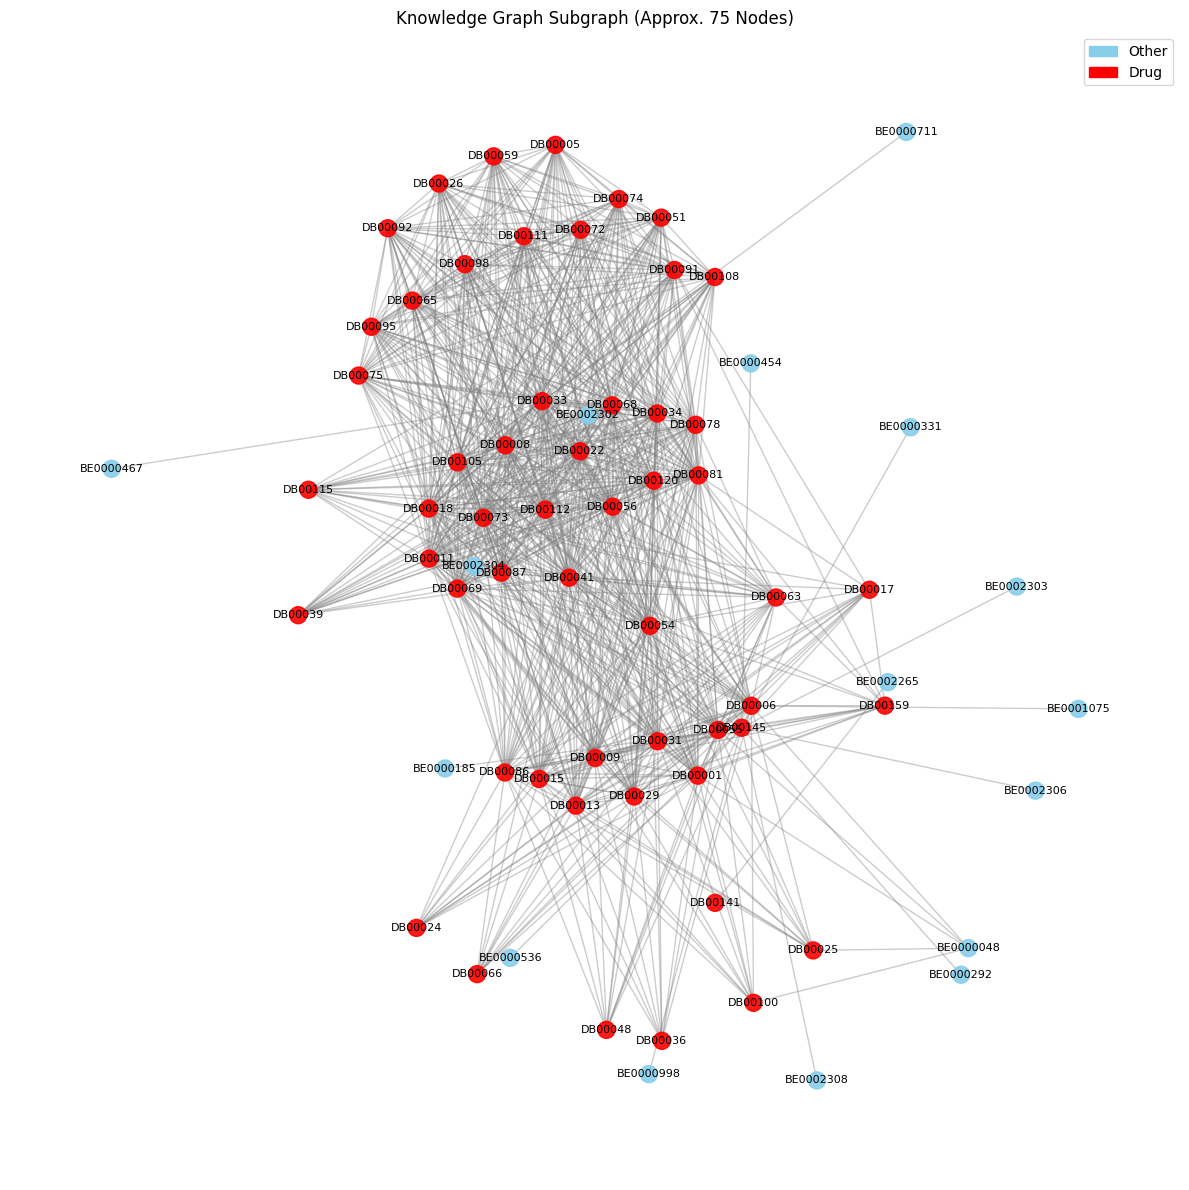

Cell 7: KG Visualization Complete.


In [16]:
# Cell 7: Visualization Helper Functions and KG Subgraph Plot (Corrected Syntax)

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np # Make sure numpy is imported if not already in Cell 1

# --- Helper Functions ---
# (Keep get_entity_type_map and get_color_map exactly the same as before)
def get_entity_type_map(entity_vocab_path, drug_vocab_path):
    """Creates a simple mapping from entity index to type ('drug' or 'other')."""
    entity_vocab = pickle_load(entity_vocab_path)
    drug_vocab = pickle_load(drug_vocab_path)
    if entity_vocab is None or drug_vocab is None:
        print("Error: Vocab files not found for type mapping.")
        return None, None

    idx2entity = {v: k for k, v in entity_vocab.items()}
    entity_type_map = {}
    drug_ids = set(drug_vocab.keys())
    for idx, entity_id_str in idx2entity.items():
        if entity_id_str in drug_ids:
            entity_type_map[idx] = 'drug'
        else:
            entity_type_map[idx] = 'other'
    return entity_type_map, idx2entity

def get_color_map(entity_type_map):
    """Assigns colors based on entity type."""
    colors = {'drug': 'red', 'other': 'skyblue', 'target': 'orange', 'gene': 'lightgreen'}
    node_colors_list = []
    if entity_type_map:
         # Ensure the list covers all possible indices up to the max index found
         max_index = max(entity_type_map.keys()) if entity_type_map else -1
         # Pre-fill with default color
         node_colors_list = ['gray'] * (max_index + 1)
         for i in range(max_index + 1):
              if i in entity_type_map:
                   entity_type = entity_type_map[i]
                   node_colors_list[i] = colors.get(entity_type, 'gray')
              # else: leave as gray
    return node_colors_list


# --- KG Subgraph Visualization ---

def visualize_kg_subgraph(kg_filepath, entity_vocab_path, drug_vocab_path, num_nodes_to_show=50, seed=42):
    """Visualizes a subgraph of the Knowledge Graph."""
    print("\n--- Visualizing Knowledge Graph Subgraph ---")
    # --- FIX START ---
    random.seed(seed)
    np.random.seed(seed) # for layout reproducibility
    # --- FIX END ---

    entity_type_map, idx2entity = get_entity_type_map(entity_vocab_path, drug_vocab_path)
    node_colors_list = get_color_map(entity_type_map) # Get colors for all nodes

    if entity_type_map is None or not node_colors_list:
        print("Cannot visualize KG: Type map or color map failed.")
        return

    print(f"Reading KG file: {kg_filepath}")
    triples = []
    try:
        with open(kg_filepath, 'r', encoding='utf8') as f:
            next(f) # Skip count
            for line in f:
                parts = line.strip().split()
                if len(parts) == 3:
                    try:
                        h, t, r = map(int, parts)
                        # Basic check if indices are plausible before adding
                        if 0 <= h < len(node_colors_list) and 0 <= t < len(node_colors_list):
                             triples.append((h, t, r))
                        else:
                             print(f"Warning: Triple indices ({h},{t}) out of range for color list length {len(node_colors_list)}. Skipping.")
                    except ValueError:
                        continue # Skip non-integer lines silently here
    except FileNotFoundError:
        print(f"Error: KG file {kg_filepath} not found.")
        return
    except Exception as e:
        print(f"Error reading KG file {kg_filepath}: {e}")
        return


    if not triples:
        print("No valid triples found/loaded for subgraph.")
        return

    # --- Create graph and select subset ---
    # (Keep the node selection logic the same)
    G = nx.Graph()
    nodes_in_subgraph = set()
    edges_added = 0
    if len(entity_type_map) > num_nodes_to_show:
         start_nodes = random.sample(list(entity_type_map.keys()), k=min(10, len(entity_type_map)))
    else:
         start_nodes = list(entity_type_map.keys())
    nodes_to_explore = list(start_nodes)
    nodes_in_subgraph.update(start_nodes)
    processed_nodes = set()
    while nodes_to_explore and len(nodes_in_subgraph) < num_nodes_to_show:
        current_node = nodes_to_explore.pop(0)
        if current_node in processed_nodes: continue
        processed_nodes.add(current_node)
        neighbors = set()
        for h, t, r in triples:
             if h == current_node and t not in nodes_in_subgraph: neighbors.add(t)
             if t == current_node and h not in nodes_in_subgraph: neighbors.add(h)
        new_neighbors = list(neighbors)
        random.shuffle(new_neighbors)
        for neighbor in new_neighbors:
            if len(nodes_in_subgraph) < num_nodes_to_show:
                 nodes_in_subgraph.add(neighbor)
                 if neighbor not in processed_nodes:
                     nodes_to_explore.append(neighbor)
            else: break

    # --- Add selected nodes and edges ---
    # (Keep this part the same)
    node_labels = {}
    nodes_added_to_nx = set()
    for h, t, r in triples:
        if h in nodes_in_subgraph and t in nodes_in_subgraph:
            if h not in nodes_added_to_nx:
                 G.add_node(h)
                 node_labels[h] = idx2entity.get(h, str(h))[:10]
                 nodes_added_to_nx.add(h)
            if t not in nodes_added_to_nx:
                 G.add_node(t)
                 node_labels[t] = idx2entity.get(t, str(t))[:10]
                 nodes_added_to_nx.add(t)
            G.add_edge(h, t)
            edges_added += 1

    print(f"Subgraph: {len(nodes_added_to_nx)} nodes, {edges_added} edges.")
    if not G.nodes:
         print("Subgraph is empty, cannot draw.")
         return

    # --- Plotting ---
    # (Keep plotting logic the same)
    plt.figure(figsize=(12, 12))
    try:
        # Use try-except for layout calculation as it can fail on disconnected graphs
        pos = nx.kamada_kawai_layout(G)
    except nx.NetworkXError:
         print("Kamada-Kawai layout failed (maybe disconnected graph?). Falling back to spring layout.")
         pos = nx.spring_layout(G, seed=seed) # Use spring layout as fallback


    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray')
    # Get colors only for the nodes present in the graph G
    final_node_colors = [node_colors_list[node_idx] if 0 <= node_idx < len(node_colors_list) else 'purple' # Use purple for out-of-bounds (shouldn't happen with checks)
                         for node_idx in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_size=150, node_color=final_node_colors, alpha=0.9)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

    # --- Legend ---
    # (Keep legend creation logic the same)
    legend_handles = []
    added_labels = set()
    # Handle cases where entity_type_map might not contain all nodes in G (if triples had bad indices)
    unique_types_in_subgraph = set(entity_type_map[node] for node in G.nodes() if node in entity_type_map)
    color_dict = {'drug': 'red', 'other': 'skyblue'}
    for node_type in unique_types_in_subgraph:
         color = color_dict.get(node_type, 'gray')
         label = node_type.capitalize()
         if label not in added_labels:
             legend_handles.append(patches.Patch(color=color, label=label))
             added_labels.add(label)

    plt.title(f"Knowledge Graph Subgraph (Approx. {num_nodes_to_show} Nodes)")
    if legend_handles: # Only show legend if handles were created
         plt.legend(handles=legend_handles, loc='upper right', frameon=True)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# --- Execution ---
# (Keep execution part the same)
kg_filepath = format_filename(PROCESSED_DATA_DIR, KG_FILE_TEMPLATE, dataset=DATASET_NAME)
entity_vocab_path = format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=DATASET_NAME)
drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=DATASET_NAME)

# Check if files exist before visualizing
if all(os.path.exists(p) for p in [kg_filepath, entity_vocab_path, drug_vocab_path]):
    visualize_kg_subgraph(kg_filepath, entity_vocab_path, drug_vocab_path, num_nodes_to_show=75)
else:
    print("Error: Missing required files for KG visualization. Ensure previous cells ran successfully.")

print("Cell 7: KG Visualization Complete.")

Attempting to visualize neighborhood for index: 28
Using specified index: 28
Logging Info - Loaded: ./data/drugbank_drug_vocab.pkl

--- Visualizing KGNN 2-Hop Neighborhood for Node 28 ---
Neighborhood extracted: {0: 1, 1: 4, 2: 20}
Logging Info - Loaded: ./data/drugbank_entity_vocab.pkl
Logging Info - Loaded: ./data/drugbank_drug_vocab.pkl
Adding aggregation edges...
Added 29 aggregation edges.


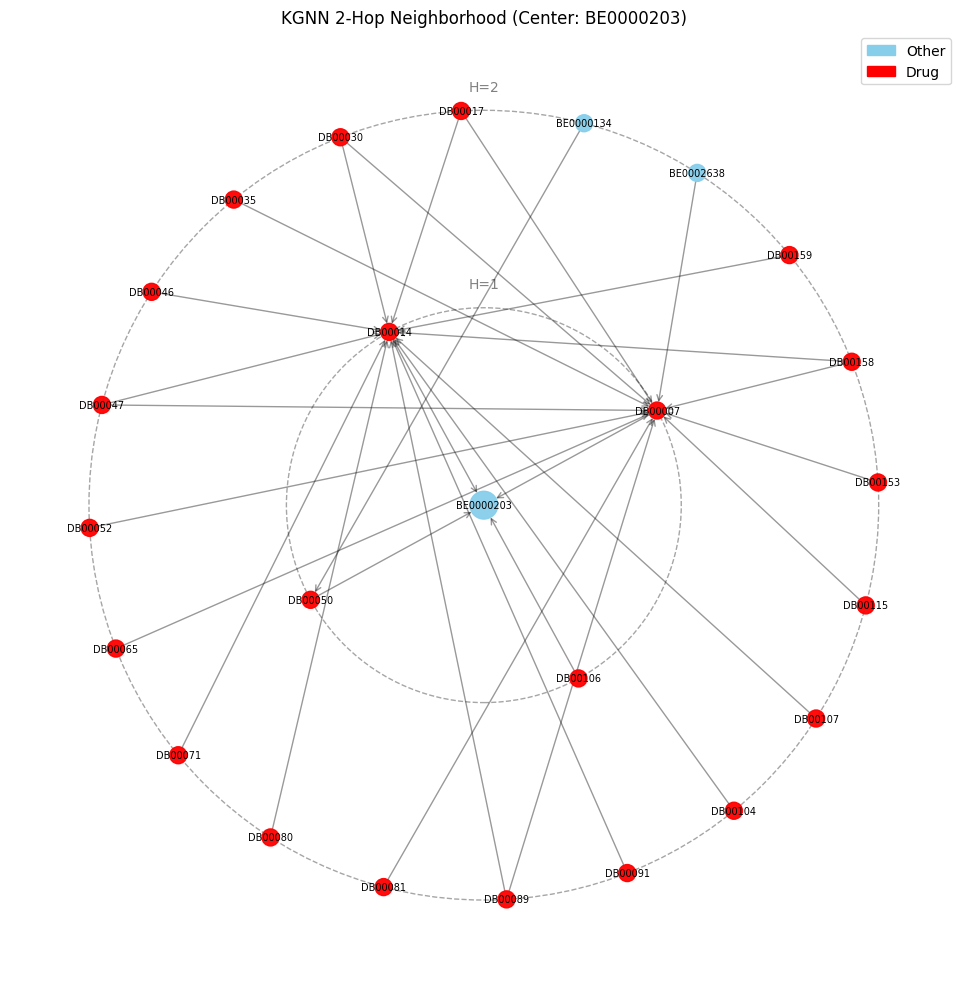

Cell 8: KGNN Visualization Complete.


In [20]:
# Cell 8: KGNN Neighborhood Visualization (Using Direct Index)

import math
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np # Ensure numpy is imported
import os # Ensure os is imported for path checks

# ========================= Helper Functions (Redefined/Copied) =========================
# (Keep these helper functions the same as in the previous versions)
def pickle_load(filename: str):
    """Load object from pickle file."""
    try:
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
        print(f'Logging Info - Loaded: {filename}')
        return obj
    except FileNotFoundError:
        print(f'Logging Error - File not found: {filename}')
        return None
    except EOFError:
        print(f'Logging Error - Cannot load (EOFError): {filename}')
        return None
    except Exception as e:
        print(f'Logging Error - General error loading {filename}: {e}')
        return None

def format_filename(_dir: str, filename_template: str, **kwargs):
    """Obtain the filename."""
    if 'DATASET_NAME' not in globals():
        global DATASET_NAME
        DATASET_NAME = 'drugbank'
    kwargs.setdefault('dataset', DATASET_NAME)
    filename = os.path.join(_dir, filename_template.format(**kwargs))
    return filename

def get_entity_type_map(entity_vocab_path, drug_vocab_path):
    """Creates a simple mapping from entity index to type ('drug' or 'other')."""
    entity_vocab = pickle_load(entity_vocab_path)
    drug_vocab = pickle_load(drug_vocab_path)
    if entity_vocab is None or drug_vocab is None:
        print("Error: Vocab files not found for type mapping.")
        return None, None
    idx2entity = {v: k for k, v in entity_vocab.items()}
    entity_type_map = {}
    drug_ids = set(drug_vocab.keys())
    for idx, entity_id_str in idx2entity.items():
        entity_type_map[idx] = 'drug' if entity_id_str in drug_ids else 'other'
    return entity_type_map, idx2entity

def get_color_map(entity_type_map):
    """Assigns colors based on entity type."""
    colors = {'drug': 'red', 'other': 'skyblue', 'target': 'orange', 'gene': 'lightgreen'}
    node_colors_list = []
    if entity_type_map:
         max_index = max(entity_type_map.keys()) if entity_type_map else -1
         node_colors_list = ['gray'] * (max_index + 1)
         for i in range(max_index + 1):
              if i in entity_type_map:
                   entity_type = entity_type_map[i]
                   node_colors_list[i] = colors.get(entity_type, 'gray')
    return node_colors_list


# ========================= KGNN Neighborhood Extraction =========================
# (Keep get_kgnn_neighborhood function the same)
def get_kgnn_neighborhood(center_node_idx, adj_entity, n_depth=2):
    if adj_entity is None:
        print("Error: Adjacency matrix not loaded.")
        return None, None
    if not (0 <= center_node_idx < adj_entity.shape[0]):
         print(f"Error: Center node index {center_node_idx} is out of bounds for adjacency matrix shape {adj_entity.shape}.")
         return None, None

    neighbors_by_hop = {0: {center_node_idx}}
    all_neighbors_found = {center_node_idx}
    current_hop_nodes = {center_node_idx}

    for h in range(1, n_depth + 1):
        next_hop_nodes = set()
        if not current_hop_nodes: break
        for node_idx in current_hop_nodes:
             if 0 <= node_idx < adj_entity.shape[0]:
                 node_neighbors = set(adj_entity[node_idx])
                 next_hop_nodes.update(node_neighbors)

        new_neighbors = next_hop_nodes - all_neighbors_found
        if not new_neighbors: break

        neighbors_by_hop[h] = new_neighbors
        all_neighbors_found.update(new_neighbors)
        current_hop_nodes = new_neighbors

    hops_to_remove = [h for h, nodes in neighbors_by_hop.items() if not nodes and h > 0]
    for h in hops_to_remove: del neighbors_by_hop[h]

    print(f"Neighborhood extracted: { {h: len(nodes) for h, nodes in neighbors_by_hop.items()} }")
    return neighbors_by_hop, all_neighbors_found


# ========================= KGNN Visualization Function =========================
# (Keep visualize_kgnn_neighborhood function the same)
def visualize_kgnn_neighborhood(center_node_idx, adj_entity, entity_vocab_path, drug_vocab_path, n_depth=2, seed=42):
    """Visualizes the H-hop neighborhood for KGNN."""
    print(f"\n--- Visualizing KGNN {n_depth}-Hop Neighborhood for Node {center_node_idx} ---")
    random.seed(seed); np.random.seed(seed)

    neighbors_by_hop, all_neighbors_found = get_kgnn_neighborhood(center_node_idx, adj_entity, n_depth)
    if neighbors_by_hop is None or not all_neighbors_found:
        print("Failed to get neighborhood or neighborhood is empty.")
        return

    entity_type_map, idx2entity = get_entity_type_map(entity_vocab_path, drug_vocab_path)
    node_colors_list = get_color_map(entity_type_map)
    if entity_type_map is None or not node_colors_list:
        print("Cannot visualize KGNN: Type map or color map failed.")
        return

    G = nx.DiGraph()
    pos = {}
    node_colors_in_graph = {}
    node_labels = {}
    center_pos = (0, 0)
    radii = {h: h * 1.0 for h in range(n_depth + 1)}
    max_radius = radii.get(max(neighbors_by_hop.keys()) if neighbors_by_hop else 0, 1.0)
    max_nodes_per_hop_for_layout = 50

    if not (0 <= center_node_idx < len(node_colors_list)):
        print(f"Error: center_node_idx {center_node_idx} invalid.")
        return

    G.add_node(center_node_idx)
    pos[center_node_idx] = center_pos
    node_colors_in_graph[center_node_idx] = node_colors_list[center_node_idx]
    node_labels[center_node_idx] = idx2entity.get(center_node_idx, str(center_node_idx))[:10]

    for hop, nodes in neighbors_by_hop.items():
        if hop == 0: continue
        radius = radii.get(hop, hop * 1.0)
        num_nodes_at_hop = len(nodes)
        display_nodes_count = min(num_nodes_at_hop, max_nodes_per_hop_for_layout)
        if display_nodes_count == 0: continue
        angle_step = 2 * math.pi / display_nodes_count if display_nodes_count > 0 else 0
        sorted_nodes = sorted(list(nodes))
        nodes_for_layout = sorted_nodes[:display_nodes_count]

        for i, node_idx in enumerate(sorted_nodes):
             if not (0 <= node_idx < len(node_colors_list)): continue
             if i < display_nodes_count:
                 angle = i * angle_step + (hop * 0.5)
                 x, y = radius * math.cos(angle), radius * math.sin(angle)
                 pos[node_idx] = (x, y)
             else:
                  angle = random.uniform(0, 2 * math.pi)
                  r_offset = random.uniform(0.9, 1.1)
                  pos[node_idx] = (radius * r_offset * math.cos(angle), radius * r_offset * math.sin(angle))
             if node_idx not in G: G.add_node(node_idx)
             node_colors_in_graph[node_idx] = node_colors_list[node_idx]
             node_labels[node_idx] = idx2entity.get(node_idx, str(node_idx))[:10]

    print("Adding aggregation edges...")
    edges_added = 0
    max_hops_present = max(neighbors_by_hop.keys()) if neighbors_by_hop else 0
    for hop in range(max_hops_present, 0, -1):
         if hop not in neighbors_by_hop or (hop - 1) not in neighbors_by_hop: continue
         current_hop_nodes = neighbors_by_hop[hop]
         prev_hop_nodes = neighbors_by_hop[hop - 1]
         for u in current_hop_nodes:
             if not (0 <= u < adj_entity.shape[0]): continue
             for v in prev_hop_nodes:
                 if not (0 <= v < adj_entity.shape[0]): continue
                 if u in adj_entity[v]:
                     if u in G and v in G:
                          G.add_edge(u, v)
                          edges_added += 1
    print(f"Added {edges_added} aggregation edges.")
    if not G.nodes: print("Graph is empty, cannot draw."); return

    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    for hop in range(1, max_hops_present + 1):
        radius = radii.get(hop, hop * 1.0)
        circle = patches.Circle(center_pos, radius, fill=False, linestyle='--', color='gray', alpha=0.7, zorder=1)
        ax.add_patch(circle)
        plt.text(0, radius + 0.1, f'H={hop}', horizontalalignment='center', color='gray', zorder=1)

    node_color_list_final = [node_colors_in_graph.get(node, 'gray') for node in G.nodes()]
    node_size_list = [400 if node == center_node_idx else 150 for node in G.nodes()]

    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='black', node_size=node_size_list,
                           arrows=True, arrowstyle='->', arrowsize=10)
    nx.draw_networkx_nodes(G, pos, node_size=node_size_list, node_color=node_color_list_final, alpha=0.95)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7)

    # --- Legend ---
    legend_handles = []
    added_labels = set()
    unique_types_in_graph = set(entity_type_map[node] for node in G.nodes() if node in entity_type_map)
    color_dict = {'drug': 'red', 'other': 'skyblue'}
    for node_type in unique_types_in_graph:
         color = color_dict.get(node_type, 'gray')
         label = node_type.capitalize()
         if label not in added_labels:
             legend_handles.append(patches.Patch(color=color, label=label))
             added_labels.add(label)

    # Use idx2entity to get the DrugBank ID for the title if possible
    center_node_label = idx2entity.get(center_node_idx, f"Index {center_node_idx}")
    plt.title(f"KGNN {n_depth}-Hop Neighborhood (Center: {center_node_label})")
    if legend_handles: plt.legend(handles=legend_handles, loc='best', frameon=True)

    plot_radius = max_radius * 1.2
    ax.set_xlim(-plot_radius, plot_radius)
    ax.set_ylim(-plot_radius, plot_radius)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# --- Execution ---
# Define file paths
# Assume PROCESSED_DATA_DIR and DATASET_NAME are globally defined
entity_vocab_path = format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=DATASET_NAME)
drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=DATASET_NAME)
adj_entity_path = format_filename(PROCESSED_DATA_DIR, ADJ_ENTITY_TEMPLATE, dataset=DATASET_NAME)

# Load required data
adj_entity = np.load(adj_entity_path) if os.path.exists(adj_entity_path) else None
# drug_vocab = pickle_load(drug_vocab_path) # No longer needed just for index selection

if adj_entity is not None:
    # --- Choose Center Node BY INDEX ---
    # *** SET YOUR DESIRED INDEX HERE ***
    TARGET_NODE_INDEX = 28 # Use the index directly

    print(f"Attempting to visualize neighborhood for index: {TARGET_NODE_INDEX}")
    center_node_idx = None # Initialize

    # Validate the chosen index
    if 0 <= TARGET_NODE_INDEX < adj_entity.shape[0]:
        center_node_idx = TARGET_NODE_INDEX
        print(f"Using specified index: {center_node_idx}")
    else:
        print(f"Error: Specified index {TARGET_NODE_INDEX} is out of bounds for adjacency matrix (shape {adj_entity.shape[0]}).")
        # Optional: Fallback to random valid index if specified one is bad
        print("Falling back to random valid index.")
        valid_indices = [idx for idx in range(adj_entity.shape[0])] # Check all possible indices
        if valid_indices:
             center_node_idx = random.choice(valid_indices)
             print(f"Using random valid index: {center_node_idx}")
        else:
             print("Error: No valid indices found in adjacency matrix range.")


    # --- Visualize ---
    if center_node_idx is not None:
        # Need drug_vocab for coloring, so load it here if needed
        drug_vocab = pickle_load(drug_vocab_path)
        if drug_vocab is not None:
             visualize_kgnn_neighborhood(center_node_idx, adj_entity, entity_vocab_path, drug_vocab_path, n_depth=2)
        else:
             print("Error: Drug vocab needed for visualization could not be loaded.")
    else:
        print("Could not determine a valid center node index for KGNN visualization.")
else:
    print("Error: Could not load adjacency matrix for KGNN visualization.")
    print(f"Checked path: {adj_entity_path}")


print("Cell 8: KGNN Visualization Complete.")